In [32]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

import shutil
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.ticker as ticker


pd.set_option("max_colwidth", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

from google.cloud import storage

In [3]:
%%time

path = 'gs://msca-bdp-students-bucket/shared_data/kaihayden/final2'

tweets_df = spark.read.parquet(path)

CPU times: user 1.04 ms, sys: 3.63 ms, total: 4.67 ms
Wall time: 6.83 s


In [4]:
tweets_df.columns

['dt_date',
 'dt_datehour',
 'dt_day',
 'dt_hour',
 'dt_month',
 'dt_year',
 'ext_qt_user_id',
 'ext_rp_user_id',
 'ext_rt_id',
 'ext_rt_user_id',
 'is_original',
 'twt_continent',
 'twt_hashtags',
 'twt_id',
 'twt_importance',
 'twt_likes',
 'twt_quote_count',
 'twt_reply_count',
 'twt_retwt_count',
 'twt_text',
 'usr_desc',
 'usr_followers',
 'usr_id',
 'usr_location',
 'usr_name',
 'usr_tweet_count',
 'usr_verified']

In [11]:
df_hour = tweets_df.groupBy('dt_hour','dt_date').agg(count('*').alias('count'))\
                   .groupBy('dt_hour').agg(mean('count').alias('mean_count'))\
                   .toPandas()

In [19]:
df_hour = df_hour.sort_values(by='dt_hour', ascending=True).set_index('dt_hour')

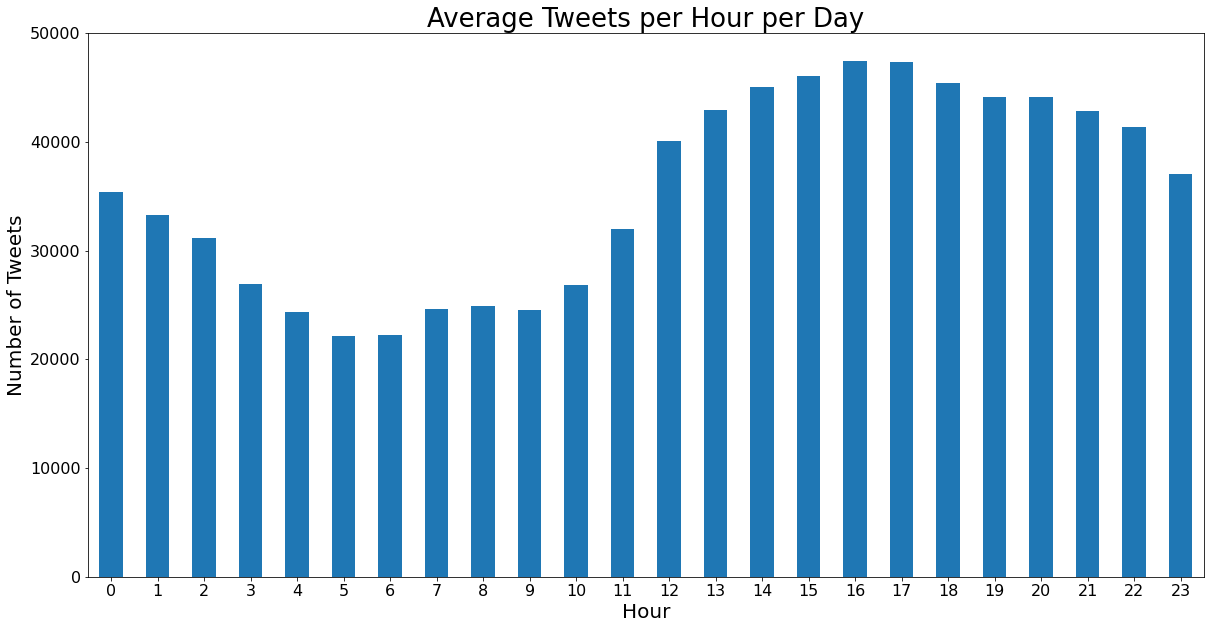

In [109]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

df_hour.plot.bar(ax=ax,legend=None)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylim([0, 50000])
ax.set_ylabel("Number of Tweets", fontsize=20)

ax.set_xlabel("Hour", fontsize=20)

ax.set_title('Average Tweets per Hour per Day', fontsize=26)

plt.savefig('./graph10.png',bbox_inches='tight')
plt.show()

In [110]:
df_hour

,mean_count
dt_hour,
0,35360.642857
1,33236.678571
2,31161.142857
3,26965.793103
4,24344.655172
5,22123.035714
6,22263.392857
7,24652.714286
8,24887.535714


### What are the timelines of these tweets? Do you see significant peaks and valleys?
- Do you see any data collection gaps?
- Plot the timelines of these tweets

In [46]:
df_timeline = tweets_df.groupBy('dt_date','dt_datehour').agg(count('*').alias('count')).toPandas()

In [123]:
df_timeline_geo1 = tweets_df.groupBy('dt_date','dt_datehour','twt_continent').agg(count('*').alias('count')).toPandas()

In [148]:
temp = df_timeline_geo1.groupby(['dt_date','twt_continent']).sum('count')
temp_pivot = pd.pivot_table(temp, values='count', index=['twt_continent'], columns=['dt_date']).transpose()
temp_pivot = temp_pivot[['NA','EU','AS','OC','AF','SA']]

In [159]:
print(temp_pivot['NA'].std()/temp_pivot['NA'].mean())
print(temp_pivot['EU'].std()/temp_pivot['EU'].mean())
print(temp_pivot['AS'].std()/temp_pivot['AS'].mean())
print(temp_pivot['OC'].std()/temp_pivot['OC'].mean())
print(temp_pivot['AF'].std()/temp_pivot['OC'].mean())
print(temp_pivot['SA'].std()/temp_pivot['SA'].mean())

0.2606316614873651
0.32347766107615344
0.3406828279937273
0.20616951907437733
0.21511976989674372
0.2367777476115755


In [139]:
temp_pivot

twt_continent,AF,AS,EU,NA,OC,SA
dt_date,,,,,,
2021-10-15,590.000000,1047.809524,2874.380952,6338.095238,630.476190,82.190476
2021-10-16,401.125000,953.250000,2423.791667,5769.208333,691.166667,69.750000
2021-10-17,370.708333,972.250000,2476.250000,5393.166667,609.500000,71.250000
2021-10-18,809.333333,1361.458333,3764.791667,10976.708333,808.666667,134.583333
2021-10-19,587.791667,1190.166667,4451.625000,9214.166667,730.458333,110.041667
2021-10-20,623.875000,1178.125000,5805.958333,8593.541667,666.916667,108.458333
2021-10-21,543.041667,2594.500000,4818.291667,6872.916667,750.000000,106.875000
2021-10-22,467.125000,1857.541667,3726.291667,6186.625000,654.000000,88.416667
2021-10-23,378.208333,1292.416667,2959.875000,4688.458333,532.583333,69.541667


In [158]:
print(temp_pivot['NA'].mean())
print(temp_pivot['EU'].mean())
print(temp_pivot['AS'].mean())
print(temp_pivot['OC'].mean())
print(temp_pivot['AF'].mean())
print(temp_pivot['SA'].mean())

160322.9655172414
71784.37931034483
27172.862068965518
13760.896551724138
11413.551724137931
2158.9655172413795


<ipython-input-152-328e85a3e901>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


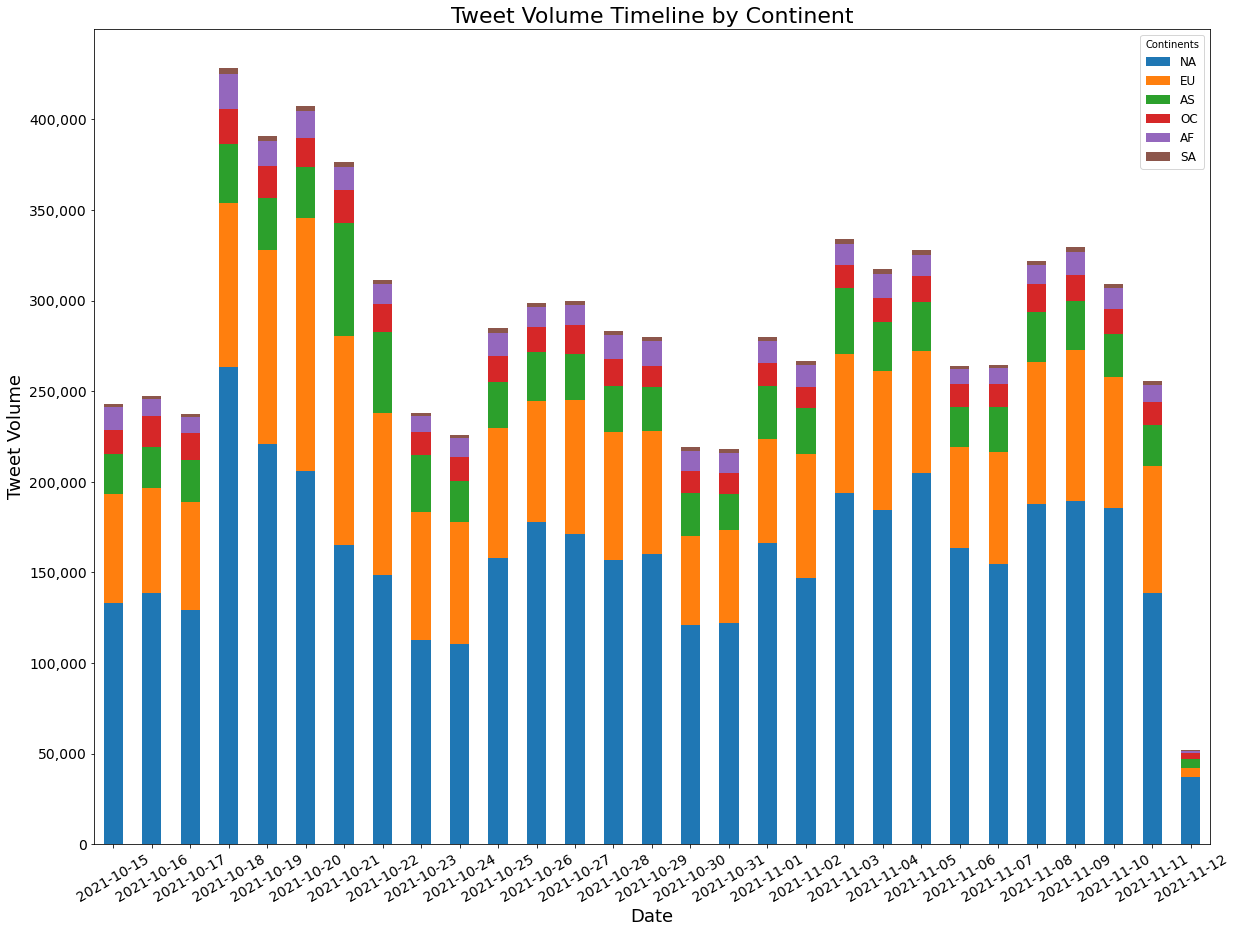

In [152]:
fig, ax = plt.subplots(1,1,figsize=(20,15))

temp_pivot.plot.bar(ax=ax, stacked=True)

ax.tick_params(axis='x', rotation=30)

ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylabel("Tweet Volume", fontsize=18)
ax.set_xlabel("Date", fontsize=18)

ax.set_title('Tweet Volume Timeline by Continent', fontsize=22)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.legend(title="Continents", fontsize=12, fancybox=True)

plt.savefig('./graph13.png',bbox_inches='tight')
plt.show()

<ipython-input-144-5950d6d51e57>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


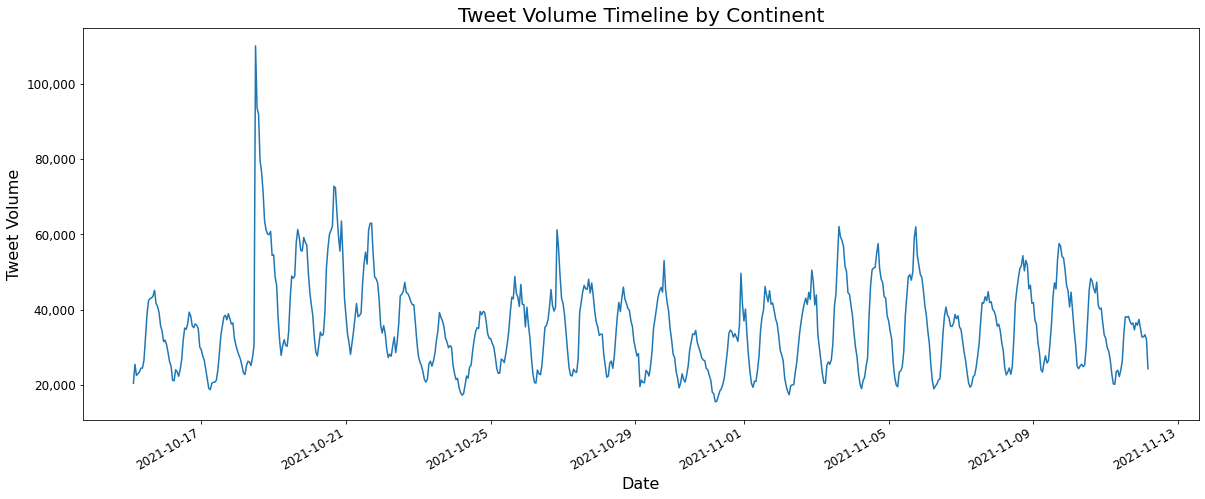

In [144]:
fig, ax = plt.subplots(1,1,figsize=(20,8))

df_timeline.plot.line(ax=ax,x='dt_datehour',y="count", legend=None)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylabel("Tweet Volume", fontsize=16)
ax.set_xlabel("Date", fontsize=16)

ax.set_title('Tweet Volume Timeline', fontsize=20)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph12.png',bbox_inches='tight')
plt.show()

In [68]:
df_timeline2 = tweets_df.groupBy('dt_date').agg(count('*').alias('count')).toPandas()

In [120]:
df_timeline_geo = tweets_df.groupBy(['dt_date','twt_continent']).agg(count('*').alias('count')).toPandas()

<ipython-input-116-699dc85e542d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


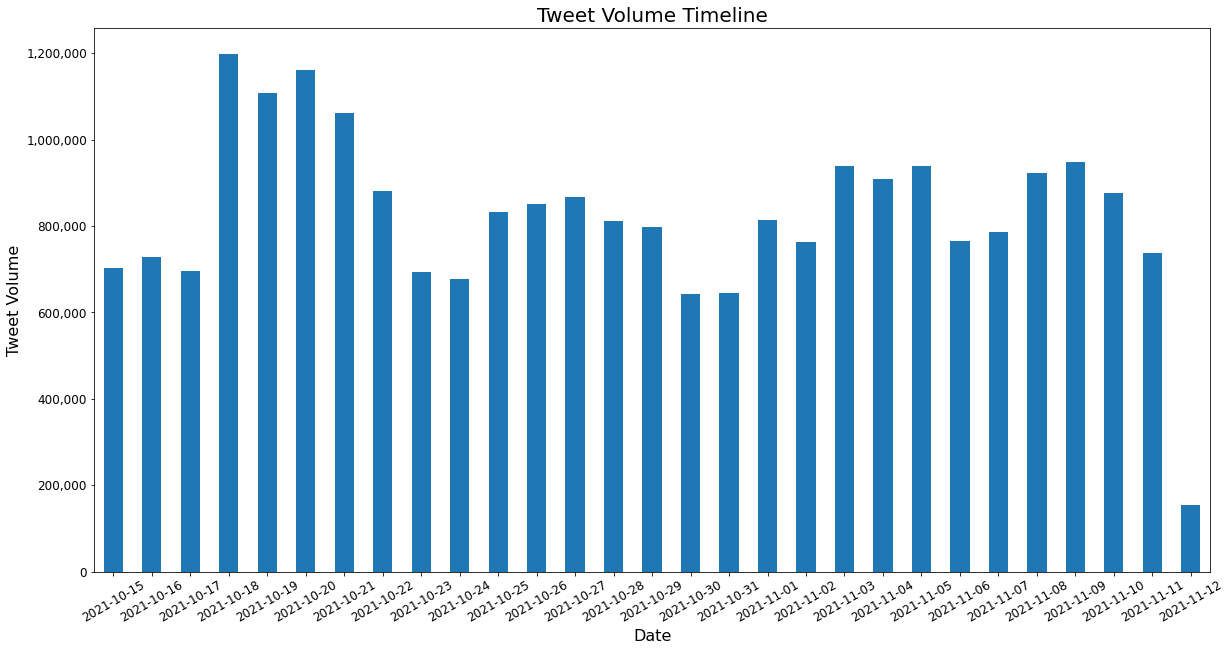

In [116]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

df_timeline2.sort_values(by='dt_date',ascending=True).plot.bar(ax=ax,x='dt_date',y="count", legend=None)

ax.tick_params(axis='x', rotation=30)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylabel("Tweet Volume", fontsize=16)
ax.set_xlabel("Date", fontsize=16)

ax.set_title('Tweet Volume Timeline', fontsize=20)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph12.png',bbox_inches='tight')
plt.show()

<ipython-input-121-5b622f2fa4d3>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


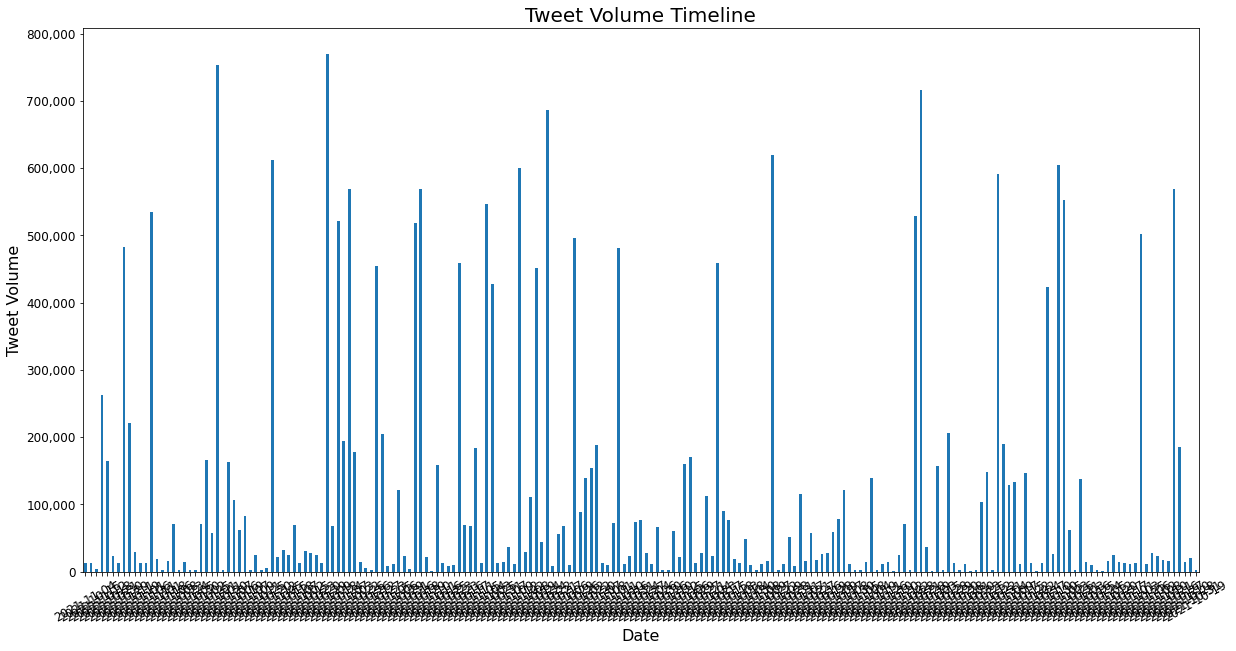

In [121]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

df_timeline_geo.plot.bar(ax=ax,x='dt_date',y="count", stacked=True, legend=None)

ax.tick_params(axis='x', rotation=30)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylabel("Tweet Volume", fontsize=16)
ax.set_xlabel("Date", fontsize=16)

ax.set_title('Tweet Volume Timeline', fontsize=20)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph12.png',bbox_inches='tight')
plt.show()

In [122]:
df_timeline_geo

,dt_date,twt_continent,count
0,2021-11-04,AF,12945
1,2021-10-15,AF,12390
2,2021-11-12,OC,3359
3,2021-10-18,NA,263441
4,2021-10-21,NA,164950
...,...,...,...
198,2021-10-27,None,568491
199,2021-11-10,NA,185812
200,2021-10-28,OC,14506
201,2021-10-31,AS,19891


In [79]:
df_timeline['dow'] = df_timeline['dt_datehour'].dt.day_name()


In [93]:
df_dow = df_timeline.groupby(['dow']).mean('count')
#                     .groupby('dow').agg(mean('count').alias('mean_count'))\


In [100]:
df_dow = df_dow.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()

In [111]:
df_dow['count'] = df_dow['count']*24

<ipython-input-112-b2d8908dbdae>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


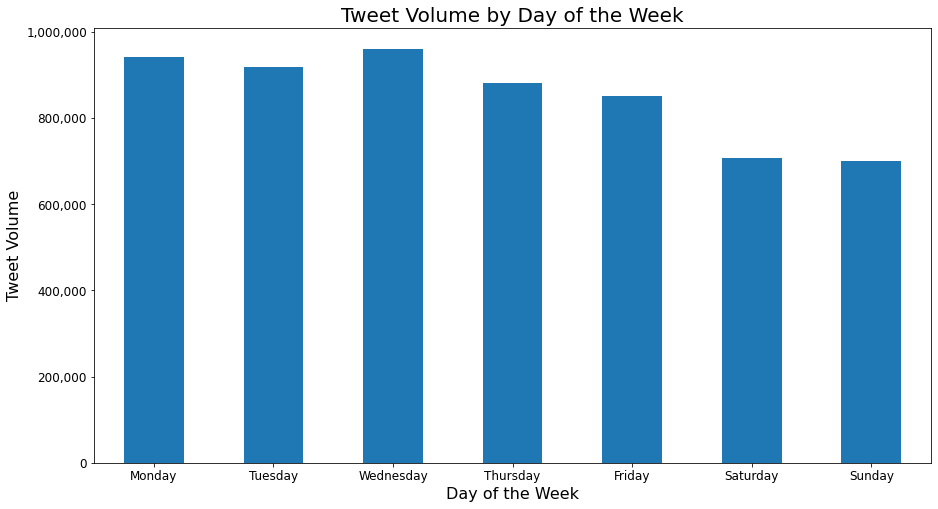

In [112]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

df_dow.plot.bar(ax=ax,x='dow',y="count", legend=None)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylabel("Tweet Volume", fontsize=16)
ax.set_xlabel("Day of the Week", fontsize=16)

ax.set_title('Tweet Volume by Day of the Week', fontsize=20)

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph11.png',bbox_inches='tight')
plt.show()

In [113]:
df_dow

,dow,count
0,Monday,941970.250000
1,Tuesday,917779.500000
2,Wednesday,961100.250000
3,Thursday,880231.250000
4,Friday,851045.632653
5,Saturday,707342.750000
6,Sunday,701147.000000
